Ремарки в 9-ой клетке, в аномальных данных. Ну идальше там.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import requests as rq
import csv
import json

# Реализация через csv-файл

## Загрузка и первоначльная обработка данных

In [4]:
# Ссылка на данные
url = "https://iss.moex.com/iss/analyticalproducts/futoi/securities.csv"

In [5]:
# Отправляем GET-запрос по указанному URL
response = rq.get(url)

# Проверяем, был ли запрос успешным (код состояния HTTP 200)
if response.status_code == 200:
    # Открываем файл для записи в бинарном режиме
    with open("securities.csv", "wb") as csv_file:
        # Записываем содержимое ответа (CSV-файла) в локальный файл
        csv_file.write(response.content)
else:
    print("Не удалось скачать файл. Код состояния HTTP:", response.status_code)

In [65]:
# Разделяем информацию в файле
with open('securities.csv', 'r', newline='') as csv_file:
  spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
  for row in spamreader:
    print('; '.join(row))

futoi

sess_id;seqnum;tradedate;tradetime;ticker;clgroup;pos;pos_long;pos_short;pos_long_num;pos_short_num;systime
6911;58;2023-10-20;23:50:00;USDRUBF;YUR;1175;115746;-114571;48;25;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;YN;FIZ;16004;23008;-7004;1360;272;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;AF;FIZ;-370;9218;-9588;298;215;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;SF;FIZ;-228772;48654;-277426;1999;4318;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;MX;FIZ;-16509;29206;-45715;1093;2844;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;AL;YUR;11760;67438;-55678;7;21;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;SN;FIZ;6534;10310;-3776;235;148;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;CNYRUBF;YUR;-58115;180355;-238470;34;9;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;EURRUBF;YUR;3162;10638;-7476;12;16;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;ED;FIZ;42426;65796;-23370;1304;731;2023-10-20; 23:50:06
6911;58;2023-10-20;23:50:00;CNYRUBF;FIZ;5811

In [20]:
# Удаляем ненужные строк с мусором в начале и конце файла
with open('securities.csv', 'r') as csv_file:
    # Создаем объект для чтения csv файла
    reader = csv.reader(csv_file)
    # Указываем количество пропускаемых в конце строчек
    rows_to_skip = len(list(reader)) - 7
    # Переносик каретку (указатель) чтения на начало файла
    csv_file.seek(0)
    # Пропускаем первую строку
    next(reader)
    # Создаем объект для чтения csv файла снова
    reader = csv.reader(csv_file)
    # Открываем csv файл для записи
    with open('new_file.csv', 'w') as new_csv_file:
        # Создаем объект для записи в csv файл
        writer = csv.writer(new_csv_file)
        # Записываем оставшиеся строки из исходного файла в новый файл
        for i, row in enumerate(reader):
            if i < rows_to_skip:
                writer.writerow(row)

In [66]:
# Выводим файл, указывая разделитель ';'
df = pd.read_csv('new_file.csv', sep=";")
df = df.sort_values(by=['ticker', 'tradetime']).reset_index().drop('index', axis=1)
#df

## Обработка данных

In [28]:
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,6)

pd.options.mode.chained_assignment = None

In [29]:
print(df.shape)
print(df.dtypes)

# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(1000, 12)
sess_id           int64
seqnum            int64
tradedate        object
tradetime        object
ticker           object
clgroup          object
pos               int64
pos_long          int64
pos_short         int64
pos_long_num      int64
pos_short_num     int64
systime          object
dtype: object
['sess_id' 'seqnum' 'pos' 'pos_long' 'pos_short' 'pos_long_num'
 'pos_short_num']
['tradedate' 'tradetime' 'ticker' 'clgroup' 'systime']


### Отсутствующие данные

<Axes: >

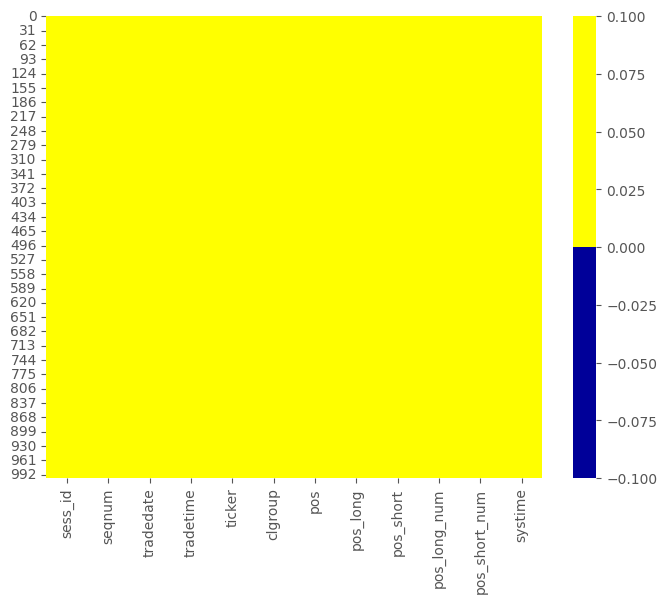

In [30]:
cols = df.columns[:1000] # первые 1000 колонок
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

В нашем случае никаких пропущенных данных нет, значит эту статистику можно пропустить

### Аномальные значения
Для поиска аномальных значений будем использовать boxplot-график и описательную статистику (квартили распределения)

***Есть ещё кластеризация и z-оценки, надо решить, будем ли их использовать***

<Axes: >

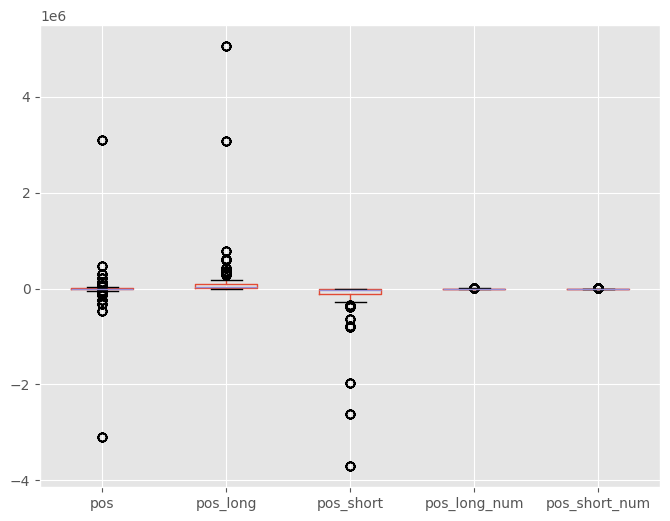

In [33]:
df.boxplot(column=['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num'])

In [13]:
df[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']].describe()

,pos,pos_long,pos_short,pos_long_num,pos_short_num
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,2.212600e+01,2.007265e+05,-2.007044e+05,1157.440000,915.810000
std,5.284036e+05,6.945461e+05,5.785303e+05,2358.450294,2351.789508
min,-3.087840e+06,5.000000e+00,-3.702084e+06,1.000000,2.000000
25%,-1.016925e+04,6.879000e+03,-1.200148e+05,18.000000,21.000000
50%,0.000000e+00,2.264800e+04,-2.335300e+04,212.500000,64.000000
75%,1.176000e+04,1.010652e+05,-5.564000e+03,1092.000000,517.500000
max,3.087840e+06,5.053721e+06,-1.000000e+01,13201.000000,16669.000000


Видно, что у нас есть явные выбросы по pos_long_num и pos_short_num.

Разделим данные на физиков и юриков, а также по тикерам.

In [60]:
df_fiz = df[df['clgroup'] == 'FIZ']
df_yur = df[df['clgroup'] == 'YUR']
# Разделение таблицы для FIZ по ticker
fiz_tables = {}
for ticker, group in df_fiz.groupby('ticker'):
    fiz_tables[ticker] = group.drop(['sess_id', 'seqnum', 'tradedate', 'tradetime', 'systime', 'ticker', 'clgroup'], axis=1).reset_index().drop('index', axis=1)


# Вывод подтаблиц для FIZ
for ticker, table in fiz_tables.items():
    print(f"Подтаблица для ticker '{ticker}':")
    print(table)

# Разделение таблицы для YUR по ticker
yur_tables = {}
for ticker, group in df_yur.groupby('ticker'):
    yur_tables[ticker] = group.drop(['sess_id', 'seqnum', 'tradedate', 'tradetime', 'systime', 'ticker', 'clgroup'], axis=1).reset_index().drop('index', axis=1)

# Вывод подтаблиц для YUR
for ticker, table in yur_tables.items():
    print(f"Подтаблица для ticker '{ticker}':")
    print(table)

Подтаблица для ticker 'AF':
    pos  pos_long  pos_short  pos_long_num  pos_short_num
0  -370      9214      -9584           300            216
1  -370      9214      -9584           300            216
2  -370      9214      -9584           299            216
3  -370      9214      -9584           299            216
4  -370      9213      -9583           299            215
5  -370      9213      -9583           299            215
6  -370      9213      -9583           299            215
7  -370      9213      -9583           299            215
8  -370      9213      -9583           299            215
9  -370      9213      -9583           299            215
10 -370      9213      -9583           298            215
11 -370      9218      -9588           298            215
12 -370      9218      -9588           298            215
13 -370      9218      -9588           298            215
Подтаблица для ticker 'AL':
      pos  pos_long  pos_short  pos_long_num  pos_short_num
0  -11760     

In [48]:
# Применим describe() к каждой подтаблице в fiz_tables и yur_tables
for ticker, table in fiz_tables.items():
    description = table[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']].describe()
    print(f"Статистика для подтаблицы ticker '{ticker}' (FIZ):")
    print(description)

for ticker, table in yur_tables.items():
    description = table[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']].describe()
    print(f"Статистика для подтаблицы ticker '{ticker}' (YUR):")
    print(description)

Статистика для подтаблицы ticker 'AF' (FIZ):
         pos     pos_long    pos_short  pos_long_num  pos_short_num
count   14.0    14.000000    14.000000     14.000000      14.000000
mean  -370.0  9214.357143 -9584.357143    298.857143     215.285714
std      0.0     2.023217     2.023217      0.662994       0.468807
min   -370.0  9213.000000 -9588.000000    298.000000     215.000000
25%   -370.0  9213.000000 -9584.000000    298.250000     215.000000
50%   -370.0  9213.500000 -9583.500000    299.000000     215.000000
75%   -370.0  9214.000000 -9583.000000    299.000000     215.750000
max   -370.0  9218.000000 -9583.000000    300.000000     216.000000
Статистика для подтаблицы ticker 'AL' (FIZ):
           pos      pos_long     pos_short  pos_long_num  pos_short_num
count     14.0     14.000000     14.000000     14.000000      14.000000
mean  -11760.0  27448.357143 -39208.357143    642.714286     418.428571
std        0.0      0.497245      0.497245      0.468807       0.513553
min   -117

Не очень понятно.

Попробуем через IQR

### Поиск аномальных значений с использованием IQR (Interquartile Range) ###

Этот код выполняет анализ данных, целью которого является поиск аномальных значений (выбросов) в указанных столбцах для каждого тикера в подтаблицах "FIZ" и "YUR". 

- Сначала создаётся список столбцов `columns_to_check`, в котором перечислены имена столбцов, для которых необходимо вычислить аномалии.

- Затем код применяет межквартильный размах (IQR) для каждого из этих столбцов в каждой из подтаблиц. IQR используется для определения границ, за которыми значения считаются выбросами.

- Для каждого тикера в подтаблице "FIZ" и "YUR" выполняются следующие шаги:
  - Вычисляются квартили (Q1 и Q3) и межквартильный размах (IQR) для текущего столбца.
  - Определяются нижняя и верхняя границы для выявления выбросов.
  - Находятся аномальные значения, которые находятся за пределами установленных границ.
  - Если в текущем столбце и для данного тикера есть аномалии, они выводятся на экран с указанием столбца и тикера.

In [67]:
import numpy as np

# Создайте список столбцов, для которых вы хотите вычислить аномальные значения
columns_to_check = ['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']

# Применение IQR для каждого столбца в подтаблице FIZ
for ticker, table in fiz_tables.items():
    if not table.empty:
        for column in columns_to_check:
            # Вычисляем межквартильный размах (IQR) для текущего столбца
            Q1 = table[column].quantile(0.25)
            Q3 = table[column].quantile(0.75)
            IQR = Q3 - Q1

            # Определяем границы для выявления выбросов
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Находим аномальные значения для текущего столбца
            anomalies = table[(table[column] < lower_bound) | (table[column] > upper_bound)]

            # Выводим аномальные значения для текущего столбца и тикера, если они есть
            if not anomalies.empty:
                print(f"Аномальные значения для столбца '{column}' и тикера '{ticker}' (FIZ):")
                print(anomalies)

# Применение IQR для каждого столбца в подтаблице YUR
for ticker, table in yur_tables.items():
    if not table.empty:
        for column in columns_to_check:
            # Вычисляем межквартильный размах (IQR) для текущего столбца
            Q1 = table[column].quantile(0.25)
            Q3 = table[column].quantile(0.75)
            IQR = Q3 - Q1

            # Определяем границы для выявления выбросов
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Находим аномальные значения для текущего столбца
            anomalies = table[(table[column] < lower_bound) | (table[column] > upper_bound)]

            # Выводим аномальные значения для текущего столбца и тикера, если они есть
            if not anomalies.empty:
                print(f"Аномальные значения для столбца '{column}' и тикера '{ticker}' (YUR):")
                print(anomalies)

Аномальные значения для столбца 'pos_long' и тикера 'AF' (FIZ):
    pos  pos_long  pos_short  pos_long_num  pos_short_num
11 -370      9218      -9588           298            215
12 -370      9218      -9588           298            215
13 -370      9218      -9588           298            215
Аномальные значения для столбца 'pos_short' и тикера 'AF' (FIZ):
    pos  pos_long  pos_short  pos_long_num  pos_short_num
11 -370      9218      -9588           298            215
12 -370      9218      -9588           298            215
13 -370      9218      -9588           298            215
Аномальные значения для столбца 'pos_short' и тикера 'BR' (FIZ):
     pos  pos_long  pos_short  pos_long_num  pos_short_num
13  1086    167048    -165962         10482           2385
Аномальные значения для столбца 'pos' и тикера 'CNYRUBF' (FIZ):
      pos  pos_long  pos_short  pos_long_num  pos_short_num
12  58115    182086    -123971          1073            916
Аномальные значения для столбца 'pos_lon

Допилить анализ

### Неинформативные признаки
Будем откидывать признаки, у которых больше 95% одинаковых значений

При разделении на таблицы откинул не нужное. Смотреть выше.

In [14]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

sess_id: 100.00000%
sess_id
6911    1000
Name: count, dtype: int64

tradedate: 100.00000%
tradedate
2023-10-20    1000
Name: count, dtype: int64



In [15]:
# Откидываем их
df.drop(['sess_id', 'tradedate'], axis=1)

,seqnum,tradetime,ticker,clgroup,pos,pos_long,pos_short,pos_long_num,pos_short_num,systime
0,58,23:50:00,USDRUBF,YUR,1175,115746,-114571,48,25,2023-10-20 23:50:06
1,58,23:50:00,YN,FIZ,16004,23008,-7004,1360,272,2023-10-20 23:50:06
2,58,23:50:00,AF,FIZ,-370,9218,-9588,298,215,2023-10-20 23:50:06
3,58,23:50:00,SF,FIZ,-228772,48654,-277426,1999,4318,2023-10-20 23:50:06
4,58,23:50:00,MX,FIZ,-16509,29206,-45715,1093,2844,2023-10-20 23:50:06
...,...,...,...,...,...,...,...,...,...,...
995,45,22:45:00,CR,FIZ,-3087007,614947,-3701954,2537,8654,2023-10-20 22:45:07
996,45,22:45:00,GZ,FIZ,136430,170857,-34427,5231,1609,2023-10-20 22:45:07
997,45,22:45:00,AL,FIZ,-11760,27448,-39208,643,418,2023-10-20 22:45:07
998,45,22:45:00,BR,YUR,-65,38682,-38747,70,46,2023-10-20 22:45:07


### Отбрасываем повторяющиеся записи

***Надо обговорить, что мы считаем под одинаковыми записями***

Мне кажется хватит функции .drop_duplicates()

```
# отбрасываем неуникальные строки
df_dedupped = df.drop('id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)
```




### Приводим всё к верхним регистрам

In [16]:
df['ticker'] = df['ticker'].str.upper()
df['clgroup'] = df['clgroup'].str.upper()
df[['ticker', 'clgroup']].value_counts(dropna=False)

ticker   clgroup
AF       FIZ        14
SF       FIZ        14
AF       YUR        14
MX       FIZ        14
         YUR        14
                    ..
CNYRUBF  FIZ        13
         YUR        13
SN       YUR        13
         FIZ        13
YN       YUR        13
Name: count, Length: 72, dtype: int64

# Через JSON

Мы работаем больше с пандовским датафреймом, поэтому csv хватит

In [17]:
# Ссылка на данные
url = "https://iss.moex.com/iss/analyticalproducts/futoi/securities.json"

In [18]:
# Отправляем GET-запрос по указанной ссылке
response = rq.get(url)

# Проверяем статус ответа
if response.status_code == 200:
    # Загружаем данные из ответа в переменную data в случае успеха
    data = response.json()
else:
    print("Ошибка при получении данных")

In [19]:
print(json.dumps(data))

{"futoi": {"metadata": {"sess_id": {"type": "int32"}, "seqnum": {"type": "int32"}, "tradedate": {"type": "date", "bytes": 10, "max_size": 0}, "tradetime": {"type": "time", "bytes": 10, "max_size": 0}, "ticker": {"type": "string", "bytes": 36, "max_size": 0}, "clgroup": {"type": "string", "bytes": 9, "max_size": 0}, "pos": {"type": "int64"}, "pos_long": {"type": "int64"}, "pos_short": {"type": "int64"}, "pos_long_num": {"type": "int64"}, "pos_short_num": {"type": "int64"}, "systime": {"type": "datetime", "bytes": 19, "max_size": 0}}, "columns": ["sess_id", "seqnum", "tradedate", "tradetime", "ticker", "clgroup", "pos", "pos_long", "pos_short", "pos_long_num", "pos_short_num", "systime"], "data": [[6911, 58, "2023-10-20", "23:50:00", "USDRUBF", "YUR", 1175, 115746, -114571, 48, 25, "2023-10-20 23:50:06"], [6911, 58, "2023-10-20", "23:50:00", "YN", "FIZ", 16004, 23008, -7004, 1360, 272, "2023-10-20 23:50:06"], [6911, 58, "2023-10-20", "23:50:00", "AF", "FIZ", -370, 9218, -9588, 298, 215, 